# Tea Leaves Categorization by Size

### import packages

In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

### read images

In [36]:
# Read the image
image_path = "images/local_image_1.JPG"
original_image = cv.imread(image_path)  #BGR Format
copy_image = original_image.copy()

### pre processing stage

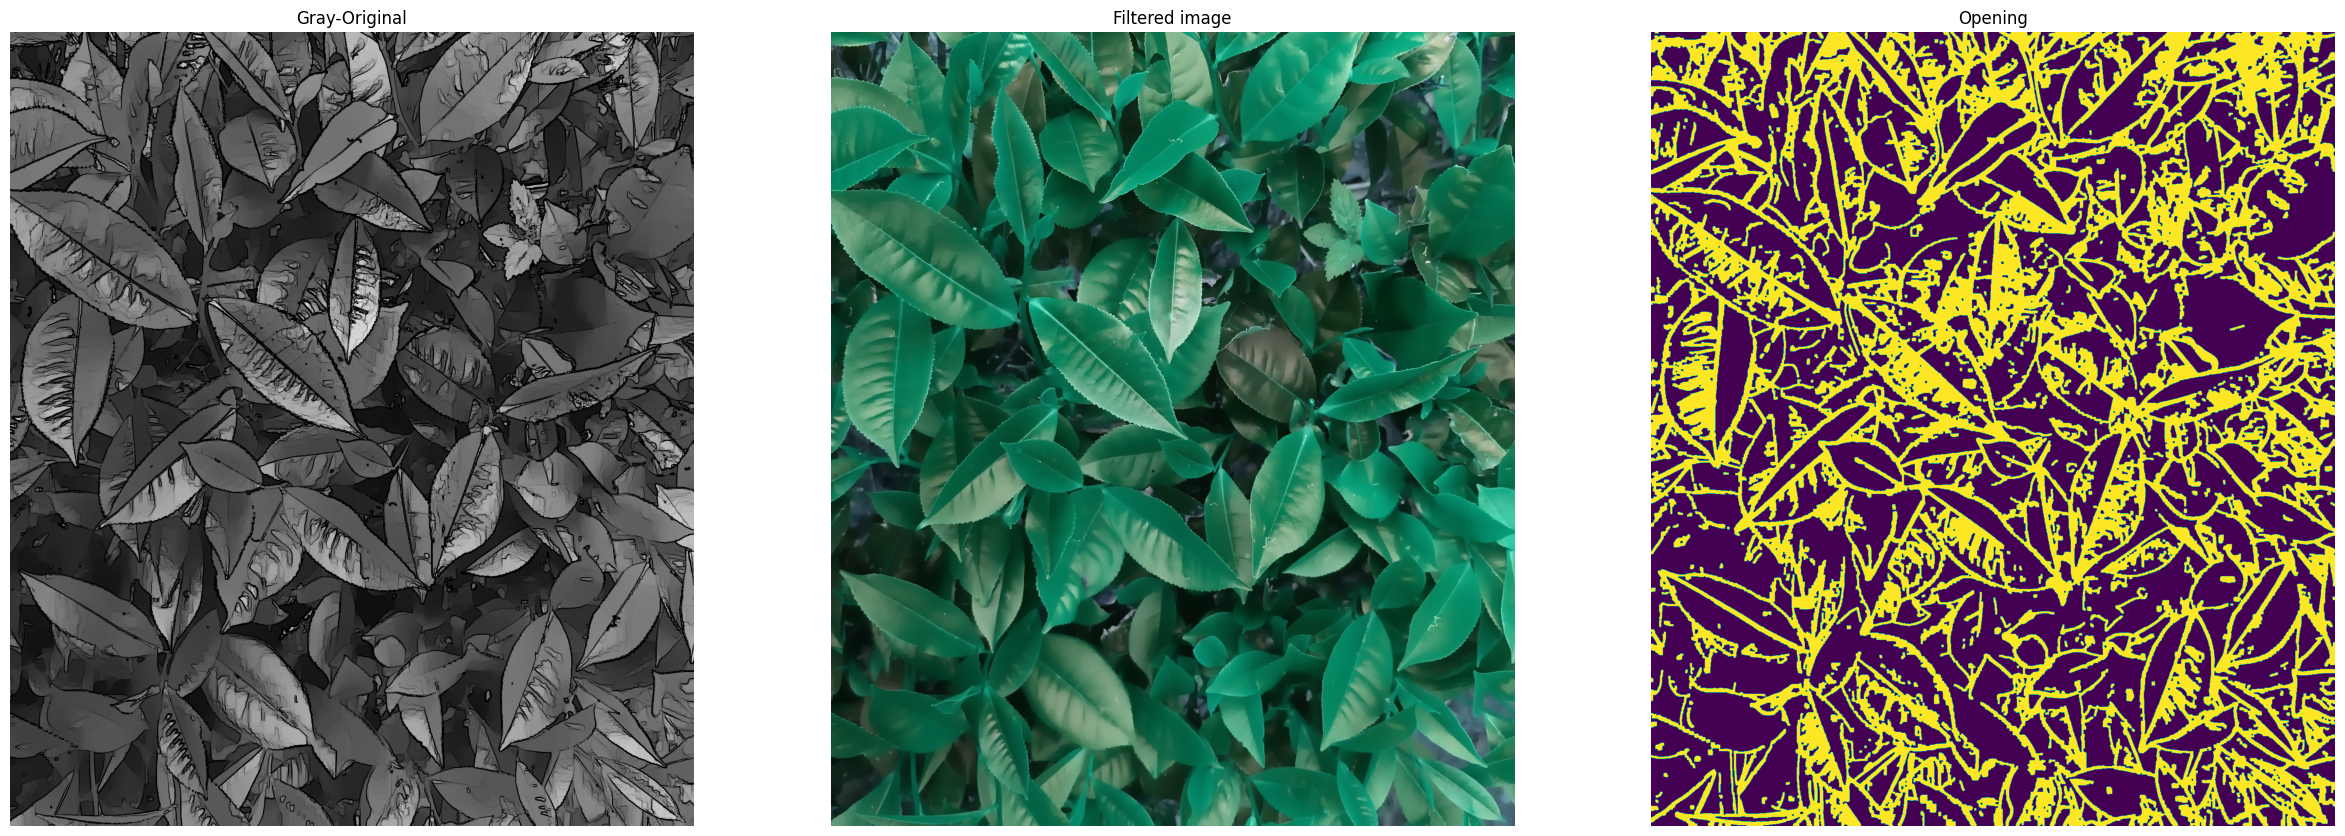

In [69]:
def preprocess_image(image):

    # Apply edge preserving filter
    # Used instead of traditional smoothing filters like Gaussian blur, which tend to blur both edges and flat regions
    # Similar to the Bilateral Filtering but works better

    filtered_image = cv.edgePreservingFilter(image, flags=cv.RECURS_FILTER, sigma_s=40, sigma_r=0.3)
    # filtered_image = cv.GaussianBlur(gray_image,(5,5),0)

    # Add water color effect to highlight the edges
    image_stylized = cv.stylization(filtered_image, sigma_s=60, sigma_r=0.07)

    # Convert to grayscale
    gray_image = cv.cvtColor(image_stylized, cv.COLOR_BGR2GRAY)

    # Step 5: Blur the background (Gaussian Blur)
    blurred_background = cv.GaussianBlur(gray_image, (11, 11), 0)

    # Step 6: Expand boundary edges (using dilation)
    kernel = np.ones((5, 5), np.uint8)
    expanded_edges = cv.dilate(blurred_background, kernel, iterations=1)

    # Apply Canny edge detection
    edges = cv.Canny(gray_image, 150, 180)

    # Perform morphological operations to close gaps and separate leaves
    kernel = np.ones((3, 3), np.uint8)
    dilated = cv.dilate(edges, kernel, iterations=3)
    eroded = cv.erode(dilated, kernel, iterations=1)

    # Display the processed images
    fig, axs = plt.subplots(1, 3, figsize=(30, 20))

    axs[0].imshow(gray_image, cmap ="gray")
    axs[0].set_title('Gray-Original')
    axs[0].axis('off')

    axs[1].imshow(filtered_image, cmap='gray')
    axs[1].set_title('Filtered image')
    axs[1].axis('off')

    axs[2].imshow(eroded)
    axs[2].set_title('Opening')
    axs[2].axis('off')

    plt.show()

    return dilated

pre_processed_img = preprocess_image(copy_image)

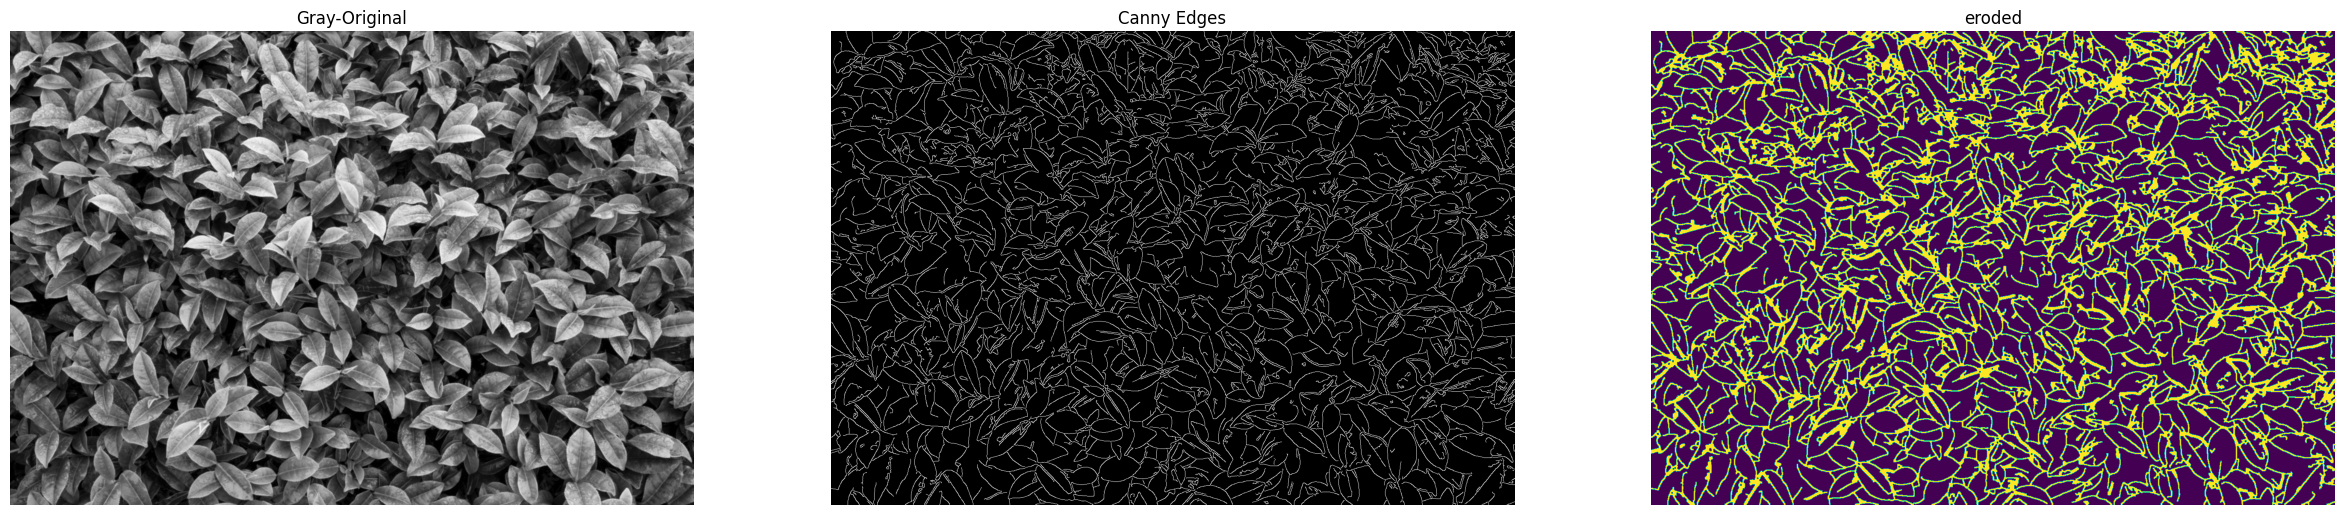

array([[[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       [[255,   0,   0],
        [ 28,  90,  54],
        [ 30,  92,  57],
        ...,
        [142, 203, 147],
        [140, 201, 144],
        [255,   0,   0]],

       [[255,   0,   0],
        [ 32,  93,  58],
        [ 33,  94,  59],
        ...,
        [118, 194, 137],
        [129, 192, 135],
        [255,   0,   0]],

       ...,

       [[255,   0,   0],
        [ 34, 105,  65],
        [ 40, 107,  67],
        ...,
        [  4,  28,   9],
        [  5,  28,   9],
        [255,   0,   0]],

       [[255,   0,   0],
        [ 34, 107,  66],
        [ 36, 104,  64],
        ...,
        [  3,  27,   8],
        [  3,  27,   8],
        [255,   0,   0]],

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]]

In [14]:



kernel = np.ones((3, 3), np.uint8)

# Perform distance transform and apply threshold
dist_transform = cv.distanceTransform(pre_processed_img, cv.DIST_L2, 5)
_, sure_fg = cv.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)

# Find unknown region
sure_bg = cv.dilate(pre_processed_img, kernel, iterations=3)
unknown = cv.subtract(sure_bg, sure_fg)

# Label markers
_, markers = cv.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers + 1

# Mark the unknown region with zero
markers[unknown == 0] = 0

# Apply watershed algorithm
markers = cv.watershed(image, markers)
image[markers == -1] = [255, 0, 0]

# Draw contours on the original image for visualization
contour_image = image.copy()
contours, _ = cv.findContours(sure_fg, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

In [15]:
# Define size categories (small, medium, large) based on contour area
size_categories = {
    'small': 0,
    'medium': 0,
    'large': 0
}

# Define thresholds for size categories
small_threshold = 500
large_threshold = 2000

# Analyze contours and categorize by size
for contour in contours:
    area = cv.contourArea(contour)
    if area < small_threshold:
        size_categories['small'] += 1
    elif area < large_threshold:
        size_categories['medium'] += 1
    else:
        size_categories['large'] += 1

# Print the size categories
print(size_categories)

{'small': 12, 'medium': 0, 'large': 0}
